In [ ]:
# Marta Baratto 07/05/2024
# A model to simultate the diffusion of negative sentiment among Apple traders on social network. In particular, we use a reddit network
# built with 5 months data (from 01/2015 to 05/2015) as topology. The diffusion is led by sis model and trust among users. 
# This notebook is made of three parts: Model creation, Calibration, Validation.

### MODEL CREATION 

In [ ]:
# Model design
import agentpy as ap
import networkx as nx 
import random 
import numpy as np
import pandas as pd
from itertools import count
from colour import Color 

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from palettable.colorbrewer.qualitative import Set2_7
from palettable.cartocolors.diverging import Temps_5

# Data analysis
import powerlaw as pwl
from scipy.stats import chisquare
from sklearn.metrics import mean_squared_error

# ODE SIS and Network base SIS
from scipy.integrate import odeint
from scipy.optimize import minimize
import EoN
from tqdm import tqdm



In [55]:
# graph=nx.barabasi_albert_graph(882,2)

# Neg=int(len(graph.nodes)*0.607595)
# Pos=len(graph.nodes)-Neg
# sentiment_data = [0] * Pos + [1] * Neg
# from random import shuffle
# shuffle(sentiment_data)

# node_sentiment=[]
# for node in list(graph.nodes):
#     node_sentiment.append(np.sum(random.choices([1,0], cum_weights = (0.607595*100,100))))

# nodes=list(graph.nodes)
# dictionary = dict(zip(nodes, node_sentiment))

# #Metto l'attributo di sentiment nella rete
# nx.set_node_attributes(graph, dictionary, "Sentiment")

In [32]:
# Upload the network

graph = nx.read_graphml(r"/mnt/c/Users/barat/Documents/Dottorato/AAA_Main_project/Network/amazon_network_5_months_right_sentiment.graphml")
sentiment=nx.get_node_attributes(graph, 'Sentiment')
sentiment_data=pd.DataFrame(sentiment.items())[1]

#Centrality
centrality = nx.katz_centrality_numpy(graph)
centrality_data=list(centrality.values())
c=centrality_data/np.max(centrality_data)

#### Network analysis

In [33]:
average_degree = round(sum(dict(graph.degree()).values()) / graph.number_of_nodes(),2)

# Print the result
print(f"The average degree is: {average_degree}")

The average degree is: 2.53


In [34]:
nodelist = list(graph.nodes)
A = nx.to_numpy_array(graph, nodelist=nodelist)

Alpha: 2.779739789278731
Minimum Degree (xmin): 1.0


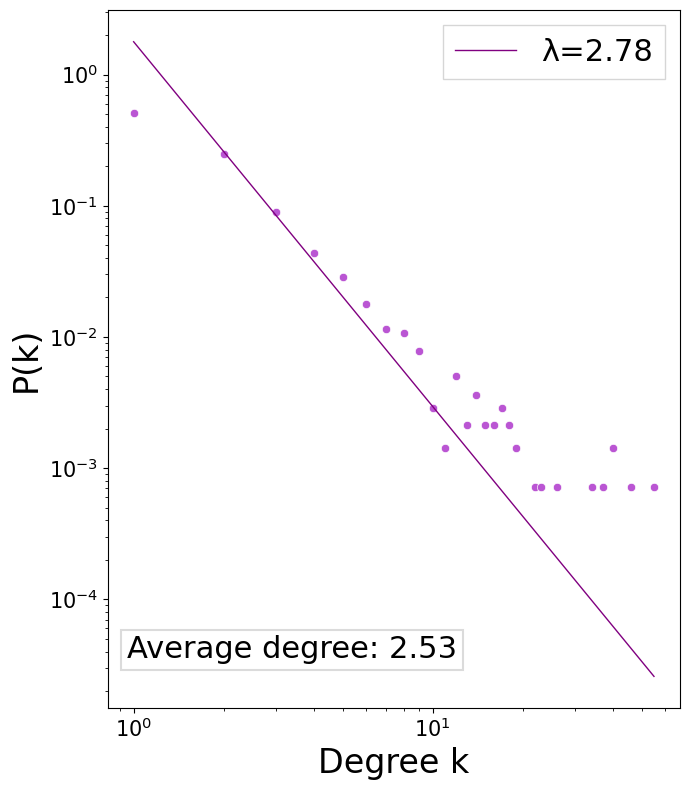

In [35]:
# Degree distribution
import powerlaw

degree_per_node = graph.degree(graph.nodes, weight="weight")
node_degree=list(degree_per_node)
degree2=pd.DataFrame(node_degree, columns=["author","degree"])
degree_freq=(degree2["degree"].value_counts())/len(graph)

# Assuming you already have 'graph' and 'degree_per_node'
degree_per_node = graph.degree(graph.nodes, weight="weight")
node_degree = list(degree_per_node)

# Create DataFrame
degree2 = pd.DataFrame(node_degree, columns=["author", "degree"])
# degree2=degree2[degree2['degree']!=1]
# Calculate frequency of degrees
degree_freq = (degree2["degree"].value_counts())/len(graph)
# degree_freq = degree_freq.iloc[1:]

# Fit the power law
fit = powerlaw.Fit(degree2["degree"], xmin=1)

# Print the alpha exponent and other fit parameters
print(f'Alpha: {fit.alpha}')
print(f'Minimum Degree (xmin): {fit.xmin}')

# Plot the empirical degree distribution using seaborn
plt.figure(figsize=(7, 8))
sns.scatterplot(x=degree_freq.index, y=degree_freq, marker='o',  color='mediumorchid') #orangered

# Adjust the scale to log-log
plt.xscale('log')
plt.yscale('log')

# Customize labels with increased font size
plt.xlabel('Degree k', fontsize=24)
plt.ylabel('P(k)', fontsize=24)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Plot the fitted power law
# x = range(min(degree_freq.index), max(degree_freq.index) + 1)
# y = [(i ** (-fit.alpha)) * (degree_freq.max()) for i in x]
# plt.plot(x,y,'o', color='orangered')

fit.power_law.plot_pdf(color='purple', linestyle='-', linewidth=1, label=f'λ={fit.alpha:.2f}')
plt.text(0.95,0.000032,'Average degree: '+ str(average_degree), fontsize = 22, va='bottom',
         bbox = dict(facecolor = 'white', alpha = 0.8, edgecolor='lightgray',linewidth=1.5))

# expected_freq = [(i ** (-fit.alpha)) * degree_freq.max() for i in degree_freq.index]
# chi2, p_value = chisquare(f_obs=degree_freq, f_exp=expected_freq)

# plt.plot(x, y, label=f'λ={fit.alpha:.2f}', color='tomato')
# plt.text(1,0.06,'Average degree: '+ str(average_degree), fontsize = 12, 
#          bbox = dict(facecolor = 'white', alpha = 0.8))

# plt.text(1, 0.03, f'Chi-Square: {chi2:.2f}', fontsize=12,
#          bbox=dict(facecolor='white', alpha=0.8))
legend=plt.legend(fontsize=22, fancybox=False) 
plt.tight_layout()
# plt.savefig(r"/mnt/c/Users/barat/Documents/Dottorato/AAA_Main_project/Apple_real_net_degree.pdf")

plt.draw()




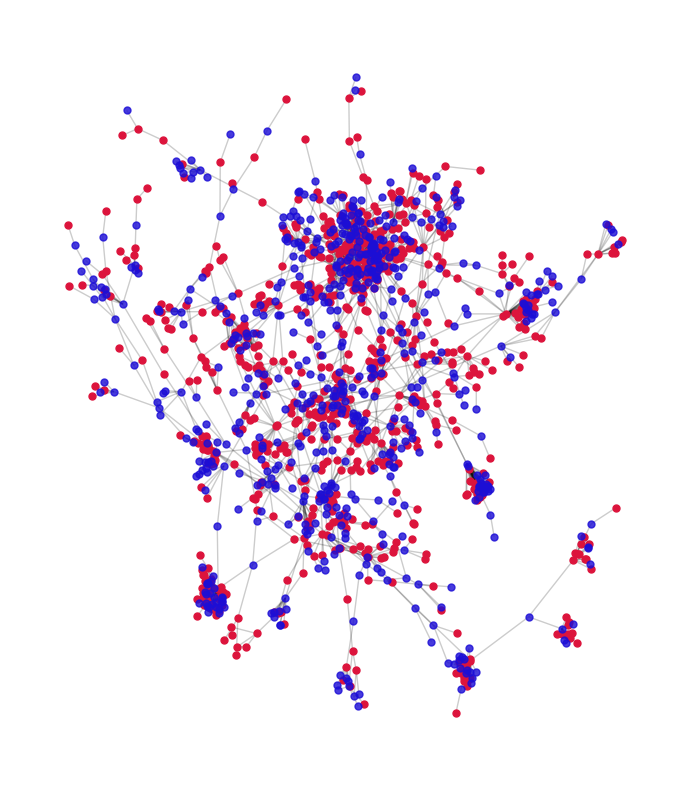

In [36]:
# Here we assign different colors to the nodes according to their sentiment

sentimento=list(nx.get_node_attributes(graph,'Sentiment').values())
nodi=list(graph.nodes)
positivi=[]
colori_pos=[]
negativi=[]
colori_neg=[]
for i in range(len(sentimento)):
    if (sentimento[i]==0):
        positivi.append(nodi[i])
        colori_pos.append(1)
    else:
        negativi.append(nodi[i])
        colori_neg.append(0)

# get unique groups
sentiments = set(nx.get_node_attributes(graph,'Sentiment').values())
mapping = dict(zip(sorted(sentiments),count()))
nodes = graph.nodes()
colors = [mapping[graph.nodes[n]['Sentiment']] for n in nodes]

plt.figure(figsize=(7,8))
# drawing nodes and edges separately so we can capture collection for colobar
pos = nx.spring_layout(graph)
ec = nx.draw_networkx_edges(graph, pos, alpha=0.2)
nx.draw_networkx_nodes(graph, pos, nodelist=negativi, node_size=25, node_color="#DC143C", label=('Negative sentiment agents'))
nx.draw_networkx_nodes(graph, pos, nodelist=positivi, node_size=25, node_color="#1C0ED6CF", label=('Positive sentiment agents'))
# nx.draw_networkx_nodes(graph, pos, nodelist=negativi, node_size=1, node_color="darkgreen", label=('Negative sentiment agents'))
# nx.draw_networkx_nodes(graph, pos, nodelist=positivi, node_size=1, node_color="darkgreen", label=('Positive sentiment agents'))
plt.axis('off')
# plt.show(block=False)
# plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig(r"Google_real_net_sentiment1.pdf")
plt.draw()

##DC143C

#### Sentiment time series visualization

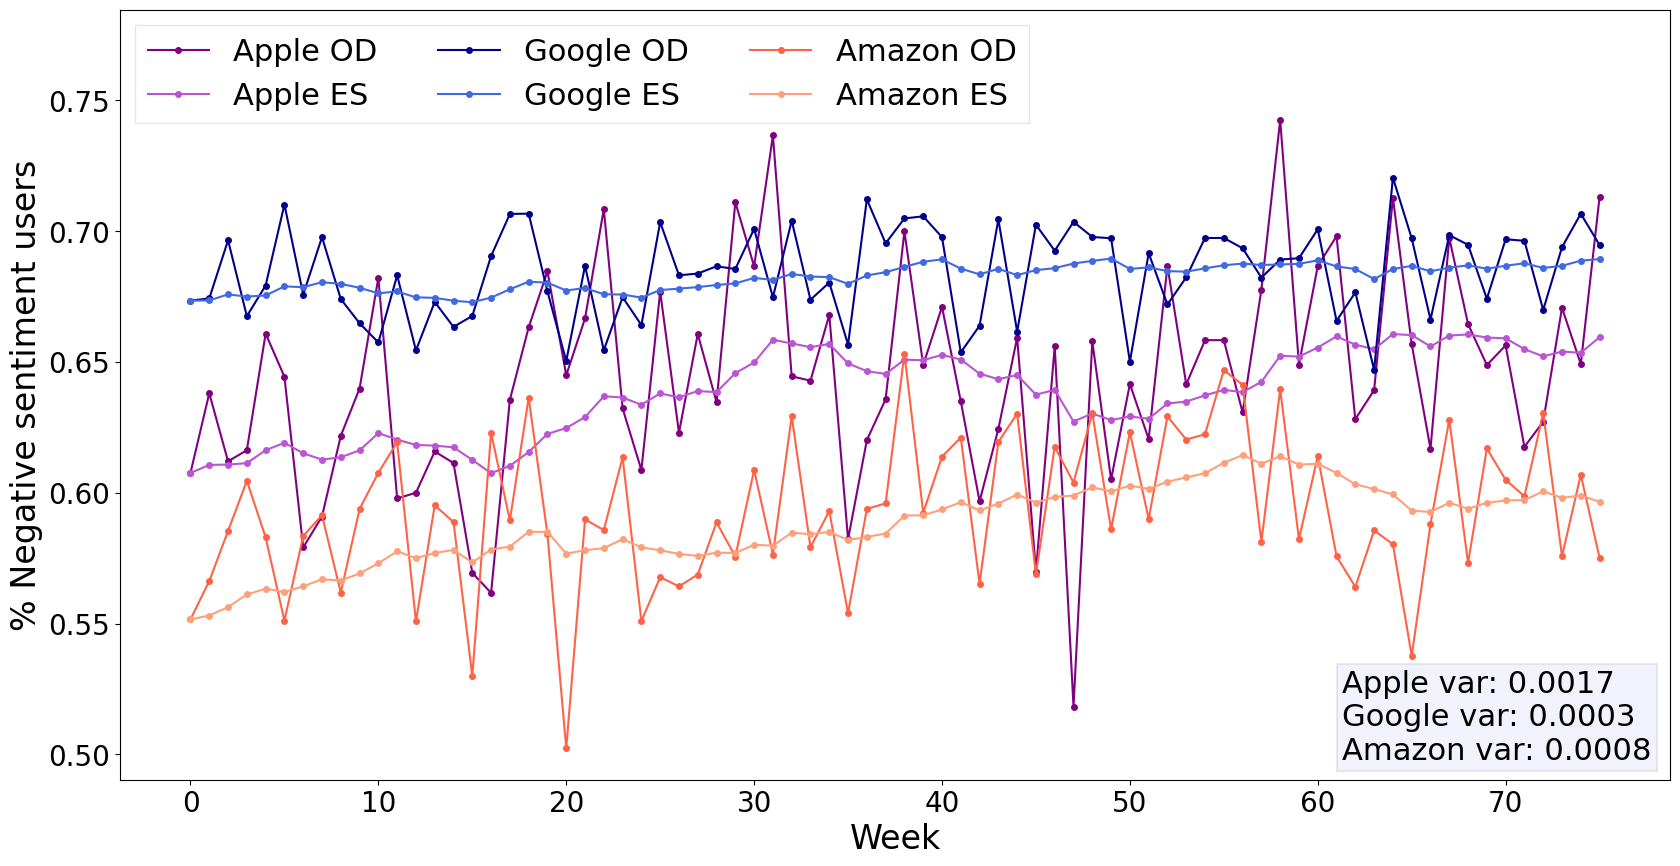

In [38]:
df=pd.read_json(r"/mnt/c/Users/barat/Documents/Dottorato/AAA_Main_project/Network/apple_sentiment_series.json")
sentiment=df['neg']

# Let's consider just a part of our dataset, we leave out the last two month so we will try to predict them
df_train=df[0:68]
sentiment_train=sentiment[0:68]

df_Google=pd.read_json(r"/mnt/c/Users/barat/Documents/Dottorato/AAA_Main_project/Network/google_sentiment_series.json")
sentiment_Google=df_Google['neg']
# sentiment_Google=sentiment_Google[0:68]

df_Amazon=pd.read_json(r"/mnt/c/Users/barat/Documents/Dottorato/AAA_Main_project/Network/amazon_sentiment_series.json")
sentiment_Amazon=df_Amazon['neg']
# sentiment_Amazon=sentiment_Amazon[0:68]
alpha = 0.1

# Exponential Smoothing
smoothed_data = np.zeros_like(sentiment)  # Initialize smoothed data array
smoothed_data[0] = sentiment[0]  # Seed the first value
for i in range(1, len(sentiment)):
    smoothed_data[i] = alpha * sentiment[i] + (1 - alpha) * smoothed_data[i-1]

smoothed_data_a = np.zeros_like(sentiment_Amazon)  # Initialize smoothed data array
smoothed_data_a[0] = sentiment_Amazon[0]  # Seed the first value
for i in range(1, len(sentiment_Amazon)):
    smoothed_data_a[i] = alpha * sentiment_Amazon[i] + (1 - alpha) * smoothed_data_a[i-1]

smoothed_data_g = np.zeros_like(sentiment_Google)  # Initialize smoothed data array
smoothed_data_g[0] = sentiment_Google[0]  # Seed the first value
for i in range(1, len(sentiment_Google)):
    smoothed_data_g[i] = alpha * sentiment_Google[i] + (1 - alpha) * smoothed_data_g[i-1]

# Plot comparison
plt.figure(figsize=(20,10))
plt.plot(sentiment, 'o-', markersize=4, label='Apple OD', color='purple')
plt.plot(smoothed_data, 'o-', markersize=4, label='Apple ES', color='mediumorchid')
plt.plot(sentiment_Google, 'o-', markersize=4, label='Google OD', color='darkblue')
plt.plot(smoothed_data_g, 'o-', markersize=4, label='Google ES', color='royalblue')
plt.plot(sentiment_Amazon, 'o-', markersize=4, label='Amazon OD', color='tomato')
plt.plot(smoothed_data_a, 'o-', markersize=4, label='Amazon ES', color='lightsalmon')

plt.xlabel('Week', fontsize=24)
plt.ylabel('% Negative sentiment users', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.text(61.3,0.498,'Apple var: 0.0017 \nGoogle var: 0.0003 \nAmazon var: 0.0008', fontsize = 22, 
         bbox = dict(facecolor = 'lavender', alpha = 0.5, edgecolor='lightgray',linewidth=1.5))
plt.legend(fontsize=22, ncol=3, fancybox=False, framealpha=0.5, loc='upper left')
ymin, ymax = plt.ylim()
plt.ylim(ymin, ymax * 1.04)
plt.draw()

# plt.savefig(r"3_Sentiment_series_smoothed.pdf")

In [39]:
v_apple=np.var(sentiment)
v_google=np.var(sentiment_Google)
v_amazon=np.var(sentiment_Amazon)

Fitted beta: 0.0465, gamma: 0.0178


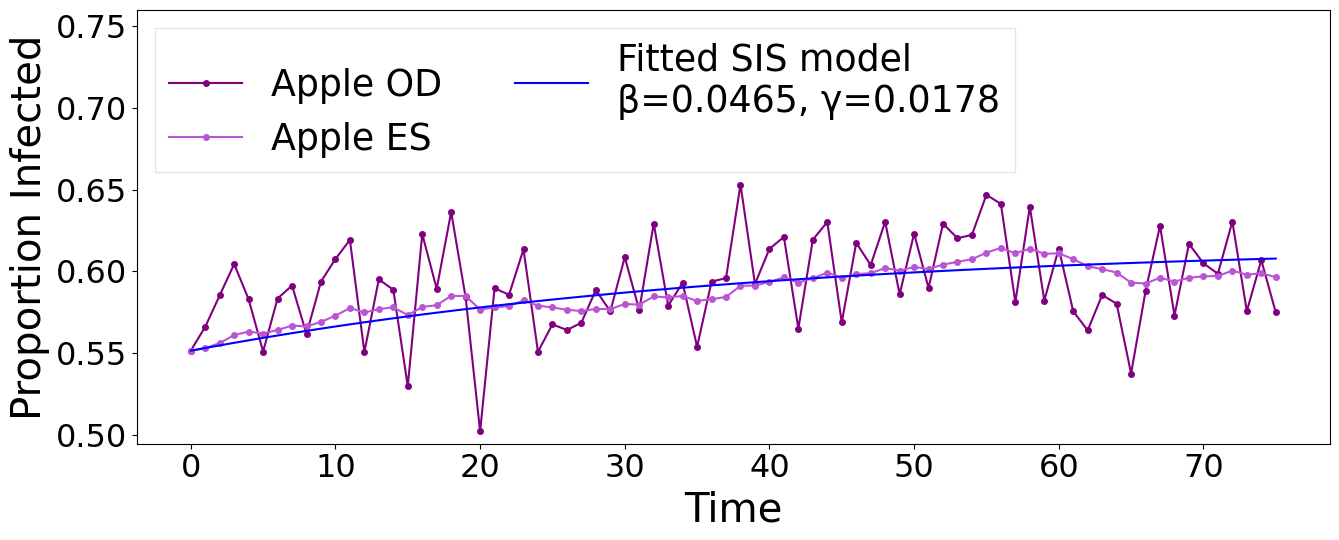

In [ ]:
t_data = np.arange(0, 68, 1, dtype=int)
i_data = smoothed_data_a[0:68] 

# ODE SIS
def sis_ode(i, t, beta, gamma):
    return beta * i * (1 - i) - gamma * i

def simulate_sis(t, i0, beta, gamma):
    return odeint(sis_ode, i0, t, args=(beta, gamma)).flatten()

def objective(params):
    beta, gamma = params
    i_sim = simulate_sis(t_data, i_data[0], beta, gamma)
    return np.mean((i_sim - i_data)**2)  # MSE

# Optimization
initial_guess = [0.3, 0.1]
bounds = [(0, 5), (0, 5)]  # vincoli ragionevoli su beta e gamma

result = minimize(objective, initial_guess, bounds=bounds)

beta_fit, gamma_fit = result.x
print(f"Fitted beta: {beta_fit:.4f}, gamma: {gamma_fit:.4f}")

# Plot
t_fit = np.arange(0, 76, 1, dtype=int)
i_fit = simulate_sis(t_fit, i_data[0], beta_fit, gamma_fit)

plt.figure(figsize=(13.5,5.5))
plt.plot(sentiment_Amazon, 'o-', markersize=4, label='Apple OD', color='purple')
plt.plot(smoothed_data_a, 'o-', markersize=4, label='Apple ES', color='mediumorchid')
plt.plot(t_fit, i_fit, label=f'Fitted SIS model\nβ={beta_fit:.4f}, γ={gamma_fit:.4f}', color='blue')
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.xlabel('Time', fontsize=29)
plt.ylabel('Proportion Infected', fontsize=29)
plt.legend(fontsize=26.2, ncol=2, fancybox=False, framealpha=0.5, loc='upper left')
# plt.grid(True)
ymin, ymax = plt.ylim()
plt.ylim(ymin, ymax*1.15)
plt.tight_layout()

# plt.savefig(r"Apple_ODE_fit.pdf")
plt.draw()


In [46]:
avg_distance=(np.sum(np.abs(smoothed_data_a[68:76]-i_fit[68:76])))/8
avg_distance

np.float64(0.009709390275010985)

#### Model definition using AgentPy

In [ ]:
# Definition of the agents, representing Reddit users, and their behaviours.
class Person(ap.Agent):
    
    def setup(self):  
        
        #S=0, I=1, R=2
        self.condition=0
        
        #Centrality measure
        self.katz=0

        #Trust che gli altri hanno nei miei confronti
        self.other_trust=np.repeat(0.5,len(graph.nodes))

    def S_behaviour_become_infected(self):

        
        #infection
        nb_hosts = 0
        nb_hosts_infected=0
        nb_neigh_sus=0
        nb_neigh_inf=0


        if (len(list(self.network.neighbors(self)))!=0):
            for n in self.network.neighbors(self):
                nb_hosts+=1
                if(n.condition ==1):
                    nb_hosts_infected+=n.other_trust[self.id-1]
                    nb_neigh_inf += 1
                if (n.condition == 0):
                    nb_neigh_sus += 1
            rate = nb_hosts_infected/nb_hosts 
            # self.condition = np.sum(random.choices([1,0], cum_weights = (min(self.p.infection_chance*rate*100,100),100)))
            self.condition = np.sum(random.choices([1,0], cum_weights = (self.p.infection_chance*rate*100,100)))
            
            # Update trust
            if (nb_neigh_sus>nb_neigh_inf):
                avg_cond=0
            else:
                avg_cond=1
            if (self.condition == avg_cond):
                for n in self.network.neighbors(self):
                    n.other_trust[self.id-1]+=0.000000001
                    if(n.condition == avg_cond):
                    #     n.other_trust[self.id-1]+=0.1
                    # else:
                    #     n.other_trust[self.id-1]-=0.1
                        n.other_trust[self.id-1]=min(n.other_trust[self.id-1]+self.p.alpha,1)
                    else:
                        n.other_trust[self.id-1]=max(n.other_trust[self.id-1]-self.p.alpha,0)
            if (self.condition != avg_cond):
                for n in self.network.neighbors(self):
                    n.other_trust[self.id-1]+=0.000000001
                    if(n.condition == avg_cond):
                    #     n.other_trust[self.id-1]+=0.1
                    # else:
                    #     n.other_trust[self.id-1]-=0.1
                         n.other_trust[self.id-1]=min(n.other_trust[self.id-1]+self.p.alpha,1)
                    else:
                        n.other_trust[self.id-1]=max(n.other_trust[self.id-1]-self.p.alpha,0)
      
    def I_behaviour_become_susceptible(self):
                               
        #becoming susceptible
        self.condition = np.sum(random.choices([0,1], cum_weights = (self.p.susceptibility_chance*100,100)))

In [48]:
# Definition of the model. We assign the network as environment where agents live, 
# call the behaviours and record the results.
class Sentiment_diffusion(ap.Model):
    
    def setup(self):
        self.shares=100
        
        #Create agents and network
        self.users = ap.AgentList(self, self.p.evolving_population, Person)
        self.network = self.users.network = ap.Network(self, graph)
        self.network.add_agents(self.users, self.network.nodes)

        #Infection according to initial sentiment
        #If Sentiment=0=pos then agent is not infected, if Sentiment=1=neg then agent is infected.
        for i in range(len(self.users)):
            if (self.users[i].condition!=sentiment_data[i]):
                self.users[i].condition=1
                
        #Katz centrality
        # for i in range(len(self.users)):
        #     self.users[i].katz=c[i]
    
             
    def update(self):    
        # Record share of agents with each condition
        for i, c in enumerate(('S', 'I')):
            n_users = len(self.users.select(self.users.condition == i))
            self[c] = n_users / self.p.evolving_population 
            self.record(c)
            
        # Record demand
        self['shares']=self.shares
        self.record('shares')

        # Trust record
        # trust_snapshot = [agent.other_trust.copy() for agent in self.users]
        # self.record('other_trust', trust_snapshot)
        
    def step(self):    
        #We call 'S_behaviour_become infected' and 'I_behaviour_become recovered' according to Persons conditions
        self.users.select(self.users.condition == 0).S_behaviour_become_infected()
        self.users.select(self.users.condition == 1).I_behaviour_become_susceptible()

        
    def end(self):     
        # Record final evaluation measures
        self.report('Total share infected', self.I) 
        self.report('Peak share infected', max(self.log['I']))

### CALIBRATION

#### Single simulations

In [ ]:
# Apple
# First run (without it the multi simulation doesn't work, I don't know exactly why).
parameters = {  
    'seed': 42,
    'evolving_population': len(graph.nodes),
    'infection_chance': 0.4556,
    # 'recovery_chance': 0.09,
    'susceptibility_chance':0.09,
    'alpha':0.072,
    'steps':75
}

model = Sentiment_diffusion(parameters)
results_apple = model.run(steps=model.p.steps) 

Completed: 75 steps
Run time: 0:00:00.860983
Simulation finished


In [ ]:
# Amazon
# First run (without it the multi simulation doesn't work, I don't know exactly why).
parameters = {  
    'seed': 42,
    'evolving_population': len(graph.nodes),
    'infection_chance': 0.05,
    # 'recovery_chance': 0.09,
    'susceptibility_chance':0.01,
    'alpha':0.015,
    'steps':75
}

model = Sentiment_diffusion(parameters)
results_amazon = model.run(steps=model.p.steps) 

Completed: 75 steps
Run time: 0:00:02.612665
Simulation finished


In [ ]:
# Google
# First run (without it the multi simulation doesn't work, I don't know exactly why).
parameters = {  
    'seed': 42,
    'evolving_population': len(graph.nodes),
    'infection_chance': 0.1,
    # 'recovery_chance': 0.09,
    'susceptibility_chance':0.017,
    'alpha':0.0147,
    'steps':75
}

model = Sentiment_diffusion(parameters)
results_google = model.run(steps=model.p.steps) 

Completed: 75 steps
Run time: 0:00:00.981077
Simulation finished


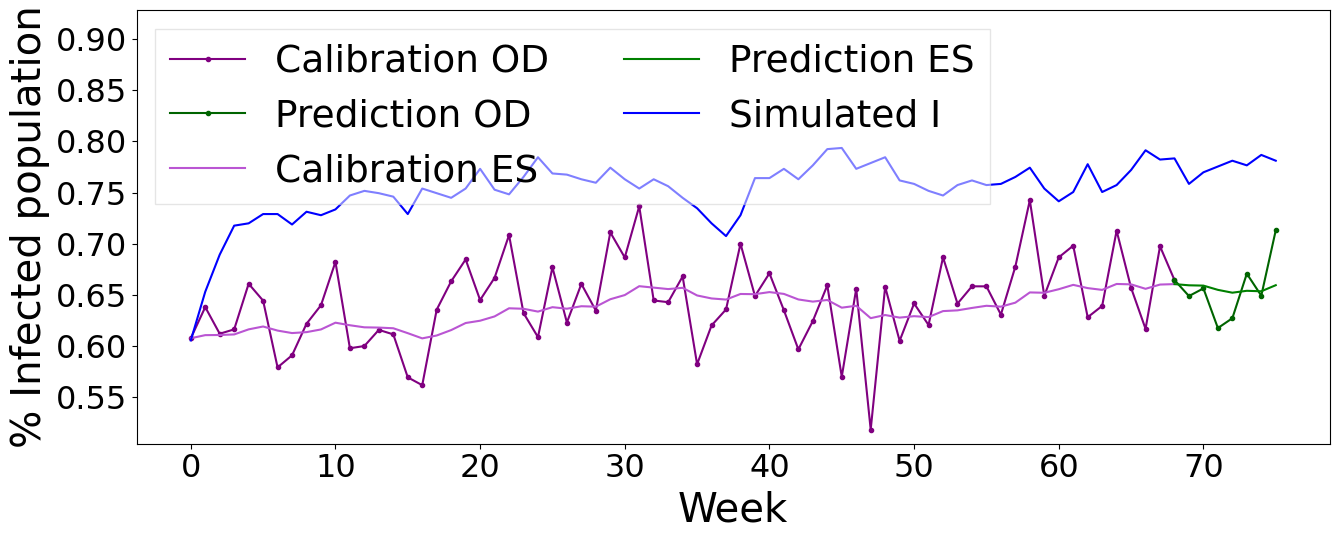

In [13]:
data=results_apple.variables.Sentiment_diffusion
S=data.S
I=data.I
time=data.index.get_level_values('t')

# data=sentiment

# Exponential Smoothing
# alpha = 0.1  # Smoothing factor (adjust for desired responsiveness)
# smoothed_data = np.zeros_like(data)  # Initialize smoothed data array
# smoothed_data[0] = data[0]  # Seed the first value
# for i in range(1, len(data)):
#     smoothed_data[i] = alpha * data[i] + (1 - alpha) * smoothed_data[i-1]

plt.figure(figsize=(13.5,5.5))

plt.plot(time[0:69], sentiment[0:69], 'o-', markersize=3, label='Calibration OD', color='purple')
plt.plot(time[68:76], sentiment[68:76], 'o-', markersize=3, label='Prediction OD', color='darkgreen')
plt.plot(time[0:69], smoothed_data[0:69], '-', markersize=3, label='Calibration ES', color='mediumorchid')
plt.plot(time[68:76], smoothed_data[68:76], '-', markersize=3, label='Prediction ES', color='green')
plt.plot(time,I, label='Simulated I', color='b')
plt.ylabel('% Infected population', fontsize=29)
plt.xlabel('Week', fontsize=29)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
ymin, ymax = plt.ylim()
plt.ylim(ymin, ymax * 1.15)
plt.tight_layout()
plt.legend(fontsize=27, fancybox=False, ncol=2, loc='upper left', framealpha=0.5)
# plt.savefig(r"una_realizzazione_1.pdf")
plt.draw()



#### Multiple simulation for calibration

In [ ]:
# Repeat the process for each company
parameters_multi = dict(parameters)
parameters_multi.update({
    'infection_chance': ap.Range(0.01,1),
    'susceptibility_chance':ap.Range(0.01,1),
    'alpha': ap.Range(0.01,1)
    # 'infection_chance':  0.01,
    # 'susceptibility_chance':0.001
})

sample = ap.Sample(parameters_multi, n=10, randomize=False)
exp = ap.Experiment(Sentiment_diffusion, sample, iterations=100, record=True)
results = exp.run(n_jobs=-1, verbose=10)
# results.save()
data_cal=results.variables.Sentiment_diffusion

In [117]:
# Choose the best curve using MSE
I=data_cal.I

var=[]
parameters=[]
for i in range(len(results.parameters.sample)):
    I_current_sample=I[I.index.get_level_values('sample_id')==i]
    h=pd.DataFrame(I_current_sample)
    a=[]
    for j in range(68):
        a.append(np.mean(h[h.index.get_level_values('t')==j]))
    variance=mean_squared_error(a,smoothed_data_a[0:68])*(len(a)+1)
    var.append(variance)
    parameters.append(i)

    d={'var':var, 'parameters':parameters}
    df=pd.DataFrame(data=d)

    best_sample=df[df['var']==np.min(df['var'])]['parameters']
    best_parameters=results.parameters.sample[results.parameters.sample.index==best_sample.iloc[0]]
    best_mse=df['var'][best_sample.index]

print(best_parameters, best_mse)

           infection_chance  susceptibility_chance
sample_id                                         
12                      0.5                   0.14 12    0.029869
Name: var, dtype: float64


### VALIDATION

#### Apple

In [ ]:
# Multi run but with the value arriving from the calibration, so only iteration of the same combination of parameters
# The parameters combination is the outcome of "best parameters" in the previous cell.

parameters_val = {  
    'seed':42,
    'evolving_population': len(graph.nodes),
    'infection_chance': 0.4556 ,
    'susceptibility_chance':0.09,
    'alpha':0.0722,
    
    'steps':75
}

model_val = Sentiment_diffusion(parameters_val)
results_val = model_val.run(steps=model_val.p.steps) 

parameters_multi_val = dict(parameters_val)
parameters_multi_val.update({
    'infection_chance': 0.4556 ,
    'susceptibility_chance':0.09,
    'alpha':0.0722,
})

sample = ap.Sample(parameters_multi_val)

exp = ap.Experiment(Sentiment_diffusion, sample, iterations=100, record=True)
results_val = exp.run(n_jobs=-1, verbose=10)
# results_val.save()

data_val=results_val.variables.Sentiment_diffusion


Completed: 75 steps
Run time: 0:00:00.545349
Simulation finished
Scheduled runs: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  88 out of 100 | elapsed:   20.0s remaining:    2.7s


Experiment finished
Run time: 0:00:21.328821


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.3s finished


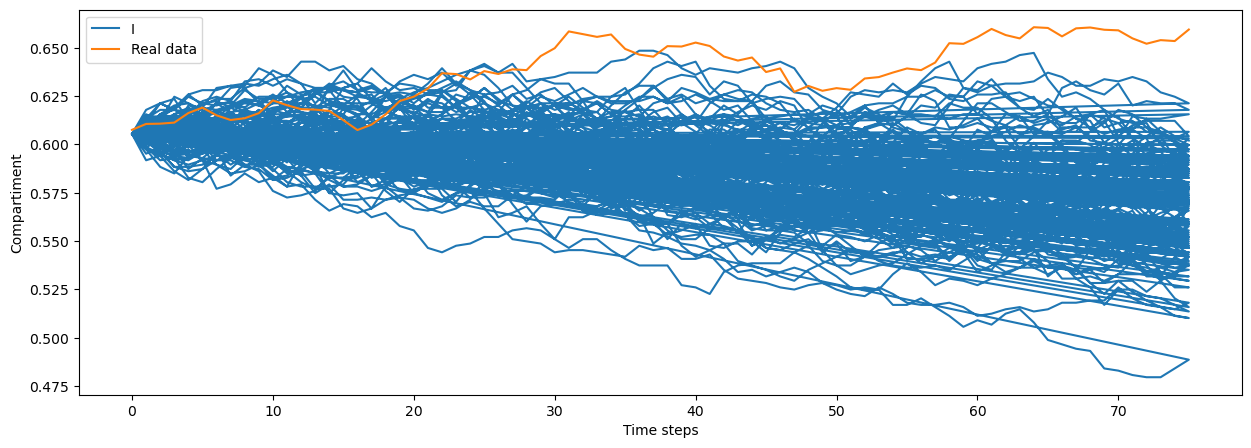

In [15]:
S=data_val.S
I=data_val.I
time=data_val.index.get_level_values('t')

plt.figure(figsize=(15,5))
# plt.plot(time, I, 'o-', markersize=1, label='I')
plt.plot(time, I, label='I')
plt.plot(time[0:76], smoothed_data, label='Real data')
plt.ylabel('Compartiment')
plt.xlabel('Time steps')
plt.legend()
plt.show()

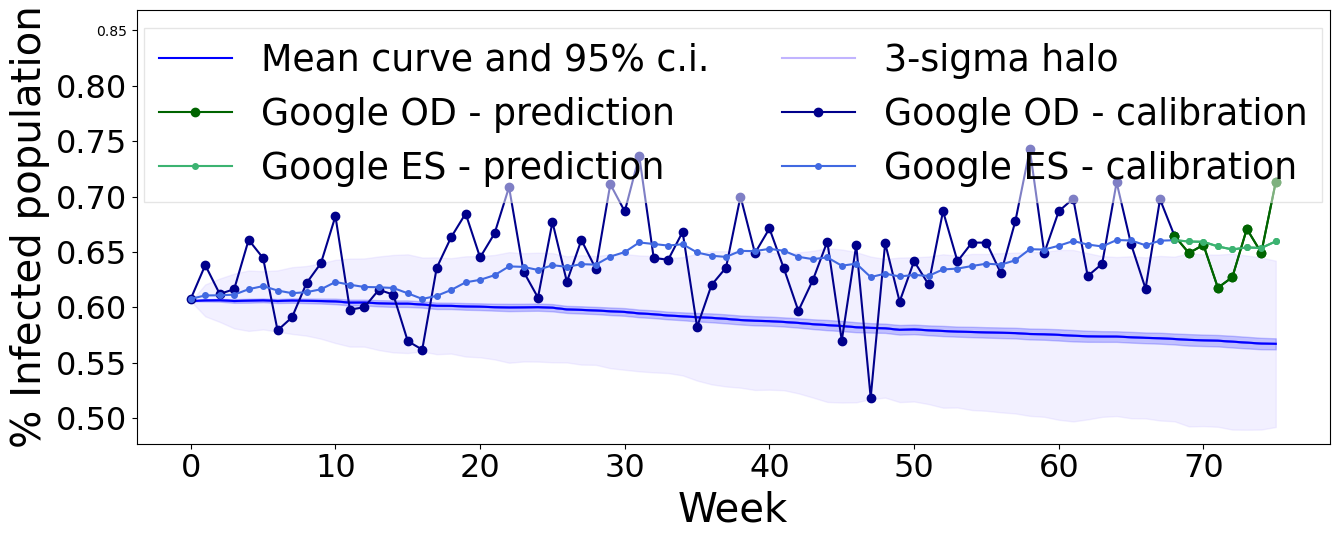

In [ ]:
# This cell has been used for the plots, changing the labels and data for each company
# plt.figure(figsize=(8,5))
plt.figure(figsize=(13.5,5.5))


sns.lineplot(
    data=results_val.arrange_variables(),
    x='t',
    y='I',
    errorbar=('se',0),
    color='b',
    label='Mean curve and 95% c.i.'
)

# plt.errorbar(time[0:68], sentiment[0:68], yerr=df_err['Propagation errors'][0:68], fmt='o-',label='Train set', color='purple')
# plt.errorbar(time[67:76], sentiment[67:76], yerr=df_err['Propagation errors'][67:76], fmt='o-',label='Test set', color='darkgreen')
# plt.plot(time[0:69], smoothed_data[0:69], 'o-', label='Train set', color='purple')
# plt.plot(time[68:76], smoothed_data[68:76], '-o', label='Test set', color='darkgreen')

plt.plot(time[68:76], sentiment[68:76], '-o', label='Google OD - prediction', color='darkgreen')
# plt.plot(time[0:76], smoothed_data[0:76], 'o-', markersize=4, label='Amazon ES', color='mediumorchid')

plt.plot(time[68:76],smoothed_data[68:76], 'o-', markersize=4, label='Google ES - prediction', color='mediumseagreen')

sns.lineplot(
    data=results_val.arrange_variables(),
    x='t',
    y='I',
    # hue='iteration',
    legend=True,
    errorbar=('sd',3),
    # palette=['lavender']
    color='#C1B4FF',
    label='3-sigma halo'
)

sns.lineplot(
    data=results_val.arrange_variables(),
    x='t',
    y='I',
    errorbar=('se',2),
    color='b'
)

plt.plot(time[0:69], sentiment[0:69], 'o-', label='Google OD - calibration', color='darkblue')
plt.plot(time[0:69],smoothed_data[0:69], 'o-', markersize=4, label='Google ES - calibration', color='royalblue')

plt.plot(time[68:76], sentiment[68:76], '-o', color='darkgreen')
plt.plot(time[68:76],smoothed_data[68:76], 'o-', markersize=4, color='mediumseagreen')

plt.xlabel("Week", fontsize=29)
plt.ylabel("% Infected population", fontsize=29)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

ymin, ymax = plt.ylim()
plt.ylim(ymin, ymax * 1.15)

plt.tight_layout()
plt.legend(fontsize=26.2, ncol=2, fancybox=False, loc='upper center', framealpha=0.5)

# plt.savefig(r"Google_76_steps_final1.pdf")
plt.draw()

In [242]:
dy=results_val.arrange_variables()
media_I = dy.groupby('t')['I'].mean().reset_index(name='I_media')
# media_I['I_media']
avg_distance=np.abs((np.sum(smoothed_data[68:76]-media_I['I_media'][68:76]))/8)
avg_distance

np.float64(0.0063705439610460685)

#### Google

In [149]:
# Multi run but with the value arriving from the calibration, so only iteration of the same combination of parameters
# The parameters combination is the outcome of "best parameters" in the previous cell.

parameters_valg = {  
    'seed':42,
    'evolving_population': len(graph.nodes),
    'infection_chance': 0.1 ,
    'susceptibility_chance':0.017,
    'alpha':0.0147,
    
    'steps':75
}

model_valg = Sentiment_diffusion(parameters_valg)
results_valg = model_valg.run(steps=model_valg.p.steps) 

parameters_multi_valg = dict(parameters_valg)
parameters_multi_valg.update({
    'infection_chance': 0.1 ,
    'susceptibility_chance':0.017,
    'alpha':0.0147,
})

sampleg = ap.Sample(parameters_multi_valg)

expg = ap.Experiment(Sentiment_diffusion, sampleg, iterations=100, record=True)
results_valg = expg.run(n_jobs=-1, verbose=10)
# results_valg.save()

data_valg=results_valg.variables.Sentiment_diffusion

Completed: 75 steps
Run time: 0:00:00.531518
Simulation finished
Scheduled runs: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  88 out of 100 | elapsed:   10.9s remaining:    1.5s


Experiment finished
Run time: 0:00:11.682837


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.7s finished


#### Amazon

In [165]:
# Multi run but with the value arriving from the calibration, so only iteration of the same combination of parameters
# The parameters combination is the outcome of "best parameters" in the previous cell.

parameters_vala = {  
    'seed':42,
    'evolving_population': len(graph.nodes),
    'infection_chance': 0.05 ,
    'susceptibility_chance':0.01,
    'alpha':0.015,
    
    'steps':75
}

model_vala = Sentiment_diffusion(parameters_vala)
results_vala = model_vala.run(steps=model_vala.p.steps) 

parameters_multi_vala = dict(parameters_vala)
parameters_multi_vala.update({
    'infection_chance': 0.05 ,
    'susceptibility_chance':0.01,
    'alpha':0.015,
})

samplea = ap.Sample(parameters_multi_vala)

expa = ap.Experiment(Sentiment_diffusion, samplea, iterations=100, record=True)
results_vala = expa.run(n_jobs=-1, verbose=10)
# results_vala.save()

data_vala=results_vala.variables.Sentiment_diffusion

Completed: 75 steps
Run time: 0:00:01.450360
Simulation finished
Scheduled runs: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  88 out of 100 | elapsed:   25.1s remaining:    3.4s


Experiment finished
Run time: 0:00:28.258426


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.2s finished


### COMPARISON WITH SIS WITHOUT TRUST
Before running this part: 
1) initialize initial trust to 1.0 
2) comment the trust update code 

---- both actions in cell 47 ----

#### Apple

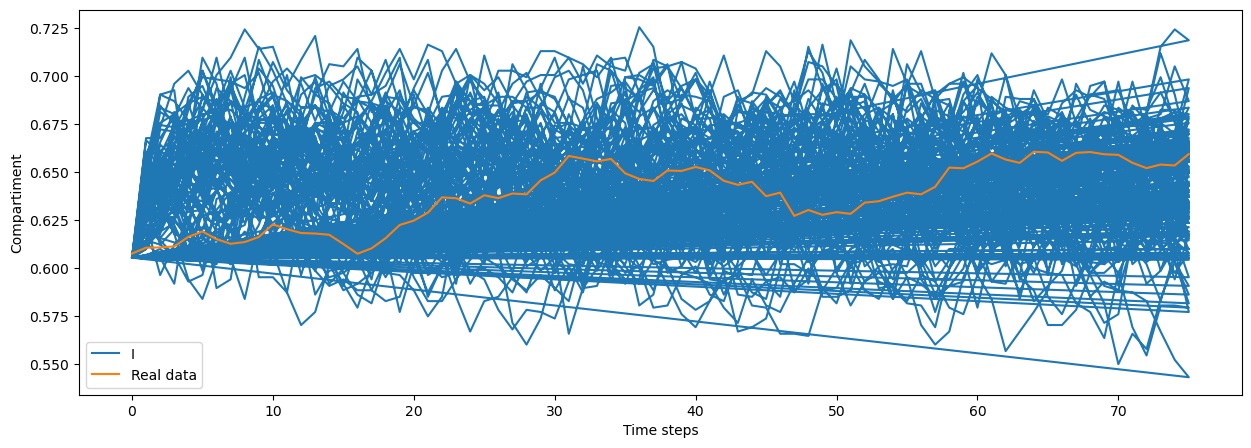

In [ ]:
# Multi run but with the value arriving from the calibration, so only iteration of the same combination of parameters
# The parameters combination is the outcome of "best parameters" in the previous cell.

parameters_val1 = {  
    'seed':42,
    'evolving_population': len(graph.nodes),
    'infection_chance': 0.5737,
    'susceptibility_chance':0.1532,
    'alpha':0.072,
    
    'steps':75
}

model_val1 = Sentiment_diffusion(parameters_val1)
results_val1 = model_val1.run(steps=model_val1.p.steps) 

parameters_multi_val1 = dict(parameters_val1)
parameters_multi_val1.update({
    'infection_chance': 0.5737,
    'susceptibility_chance':0.1532,
    'alpha':0.072,
})

sample1 = ap.Sample(parameters_multi_val1)

exp1 = ap.Experiment(Sentiment_diffusion, sample1, iterations=100, record=True)
results_val1 = exp1.run(n_jobs=-1, verbose=10)
# results_val1.save()

data_val1=results_val1.variables.Sentiment_diffusion

S1=data_val1.S
I1=data_val1.I
time1=data_val1.index.get_level_values('t')

plt.figure(figsize=(15,5))
# plt.plot(time, I, 'o-', markersize=1, label='I')
plt.plot(time1, I1, label='I')
plt.plot(time1[0:76], smoothed_data, label='Real data')
plt.ylabel('Compartiment')
plt.xlabel('Time steps')
plt.legend()
plt.show()

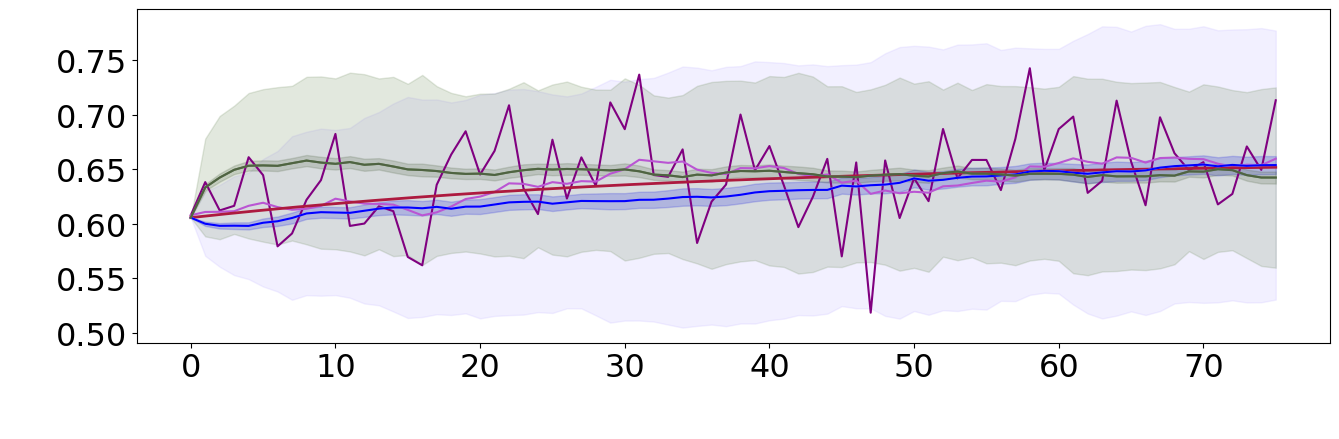

In [ ]:
# PARAMETERS
N = len(graph.nodes)

# from the deterministic SIS fit
beta_det=0.0464
gamma_det=0.0159

tmax = 75
n_simulations = 100
initial_fraction = len(negativi)/N
t_eval = np.linspace(0, tmax, 500) 

# Determinisitc SIS
def deriv(i, t, beta, gamma):
    return beta * i * (1 - i) - gamma * i

i0 = initial_fraction
i_det = odeint(deriv, i0, t_eval, args=(beta_det, gamma_det)).flatten()


# PLOT
plt.figure(figsize=(13.5,4.5))


# Mean curve + Confidence interval
# plt.plot(t_eval, mean_I2, label='SIS on network with 95% c.i.', color="#4F6342", alpha=0.8)
# plt.fill_between(t_eval, mean_I2 - ci_952, mean_I2 + ci_952, color="#4F6342", alpha=0.3)
# plt.fill_between(t_eval, sigma_3_low2, sigma_3_high2, color="#708D5E", alpha=0.15, label='3σ halo')


# plt.plot(sentiment, '-', markersize=4, label='Google OD', color='purple')
# plt.plot(smoothed_data, '-', markersize=4, label='Google ES', color='mediumorchid')
# plt.plot(t_eval, i_det, label='Deterministic SIS', color="#AD1A3F", linewidth=2)

plt.plot(sentiment, '-', markersize=4, color='purple')
plt.plot(smoothed_data, '-', markersize=4, color='mediumorchid')
plt.plot(t_eval, i_det, color="#AD1A3F", linewidth=2)

########## ---- ABM

sns.lineplot(
    data=results_val.arrange_variables(),
    x='t',
    y='I',
    # hue='iteration',
    legend=False,
    errorbar=('sd',3),
    # palette=['lavender']
    color='#C1B4FF' #,
    # label='3σ halo'
)

sns.lineplot(
    data=results_val.arrange_variables(),
    x='t',
    y='I',
    errorbar=('se',2),
    color='b'
)

###########

########## ---- SIS ON NETWORK

sns.lineplot(
    data=results_val1.arrange_variables(),
    x='t',
    y='I',
    # hue='iteration',
    legend=False,
    errorbar=('sd',3),
    # palette=['lavender']
    color='#708D5E' #,
    # label='3σ halo'
)

sns.lineplot(
    data=results_val1.arrange_variables(),
    x='t',
    y='I',
    errorbar=('se',2),
    color='#4F6342'
)

###########


plt.xlabel('Time',fontsize=29, color='white')
plt.ylabel('Proportion Infected', fontsize=29, color='white')



plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

custom_legend = [
    Line2D([0], [0], color='purple', label='Apple OD', lw=2),
    Line2D([0], [0], color='mediumorchid', label='Apple ES', lw=2),
    Line2D([0], [0], color="#AD1A3F", lw=2, label='SIS'),
    Line2D([0], [0], color="#4F6342", lw=2, label='Network SIS'),
    Patch(facecolor="#708D5E", alpha=0.15, label='Network SIS 3σ'),
    Line2D([0], [0], color="b", lw=2, label='ABM'),
    Patch(facecolor="#C1B4FF", alpha=0.3, label='ABM 3σ')
]

# plt.legend(handles=custom_legend, fontsize=26.2, ncols=3, loc='upper center', fancybox=False, framealpha=0.5)
ymin, ymax = plt.ylim()
plt.ylim(ymin, ymax*1)
plt.tight_layout()

# plt.savefig(r"Apple_comparison1.pdf")
plt.draw()

#### Google

In [25]:
# Multi run but with the value arriving from the calibration, so only iteration of the same combination of parameters
# The parameters combination is the outcome of "best parameters" in the previous cell.

parameters_valg1 = {  
    'seed':42,
    'evolving_population': len(graph.nodes),
    'infection_chance': 0.5778 ,
    'susceptibility_chance':0.137778,
    'alpha':0.0722,
    
    'steps':75
}

model_valg1 = Sentiment_diffusion(parameters_valg1)
results_valg1 = model_valg1.run(steps=model_valg1.p.steps) 

parameters_multi_valg1 = dict(parameters_valg1)
parameters_multi_valg1.update({
    'infection_chance': 0.5778 ,
    'susceptibility_chance':0.137778,
    'alpha':0.0722,
})

sampleg1 = ap.Sample(parameters_multi_valg1)

expg1 = ap.Experiment(Sentiment_diffusion, sampleg1, iterations=100, record=True)
results_valg1 = expg1.run(n_jobs=-1, verbose=10)
# results_valg1.save()

data_valg1=results_valg1.variables.Sentiment_diffusion

Completed: 75 steps
Run time: 0:00:00.394300
Simulation finished
Scheduled runs: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  88 out of 100 | elapsed:   10.5s remaining:    1.4s


Experiment finished
Run time: 0:00:11.641828


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.6s finished


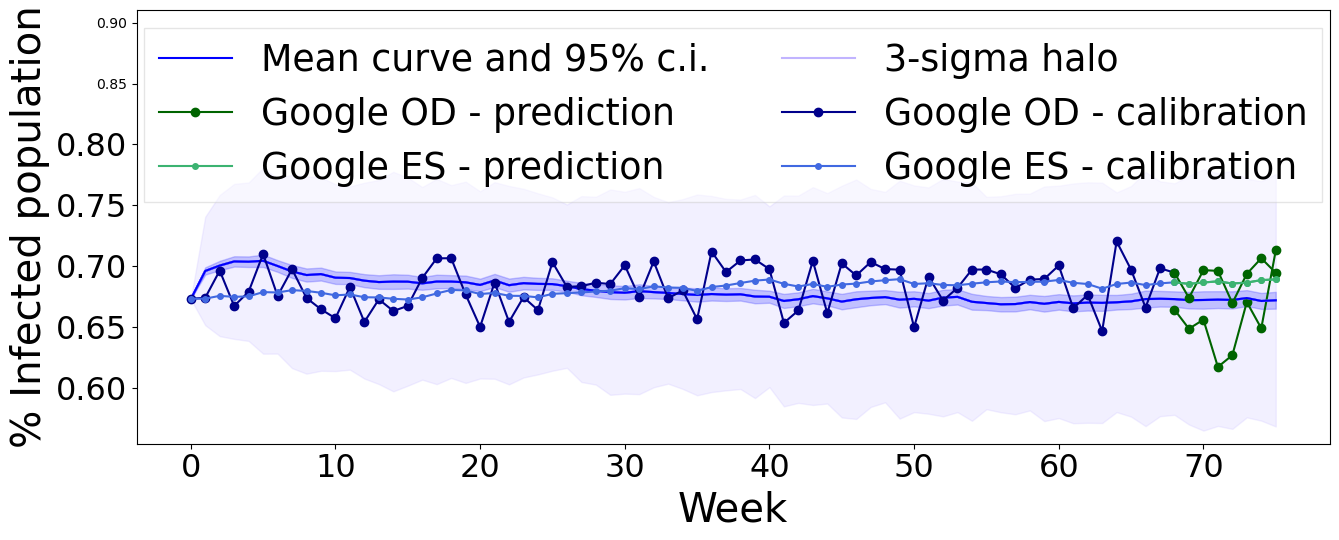

In [27]:
# plt.figure(figsize=(8,5))
plt.figure(figsize=(13.5,5.5))


sns.lineplot(
    data=results_valg1.arrange_variables(),
    x='t',
    y='I',
    errorbar=('se',0),
    color='b',
    label='Mean curve and 95% c.i.'
)

# plt.errorbar(time[0:68], sentiment[0:68], yerr=df_err['Propagation errors'][0:68], fmt='o-',label='Train set', color='purple')
# plt.errorbar(time[67:76], sentiment[67:76], yerr=df_err['Propagation errors'][67:76], fmt='o-',label='Test set', color='darkgreen')
# plt.plot(time[0:69], smoothed_data[0:69], 'o-', label='Train set', color='purple')
# plt.plot(time[68:76], smoothed_data[68:76], '-o', label='Test set', color='darkgreen')

plt.plot(time[68:76], sentiment[68:76], '-o', label='Google OD - prediction', color='darkgreen')
# plt.plot(time[0:76], smoothed_data[0:76], 'o-', markersize=4, label='Amazon ES', color='mediumorchid')

plt.plot(time[68:76],smoothed_data_g[68:76], 'o-', markersize=4, label='Google ES - prediction', color='mediumseagreen')

sns.lineplot(
    data=results_valg1.arrange_variables(),
    x='t',
    y='I',
    # hue='iteration',
    legend=True,
    errorbar=('sd',3),
    # palette=['lavender']
    color='#C1B4FF',
    label='3-sigma halo'
)

sns.lineplot(
    data=results_valg1.arrange_variables(),
    x='t',
    y='I',
    errorbar=('se',2),
    color='b'
)

plt.plot(time[0:69], sentiment_Google[0:69], 'o-', label='Google OD - calibration', color='darkblue')
plt.plot(time[0:69],smoothed_data_g[0:69], 'o-', markersize=4, label='Google ES - calibration', color='royalblue')

plt.plot(time[68:76], sentiment_Google[68:76], '-o', color='darkgreen')
plt.plot(time[68:76],smoothed_data_g[68:76], 'o-', markersize=4, color='mediumseagreen')

plt.xlabel("Week", fontsize=29)
plt.ylabel("% Infected population", fontsize=29)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

ymin, ymax = plt.ylim()
plt.ylim(ymin, ymax * 1.15)

plt.tight_layout()
plt.legend(fontsize=26.2, ncol=2, fancybox=False, loc='upper center', framealpha=0.5)

# plt.savefig(r"Google_76_steps_final1.pdf")
plt.draw()

In [28]:
dy=results_valg1.arrange_variables()
media_I = dy.groupby('t')['I'].mean().reset_index(name='I_media')
# media_I['I_media']
avg_distance=np.abs((np.sum(smoothed_data_g[68:76]-media_I['I_media'][68:76]))/8)
avg_distance

np.float64(0.014605624681837723)

#### Amazon

In [49]:
# Multi run but with the value arriving from the calibration, so only iteration of the same combination of parameters
# The parameters combination is the outcome of "best parameters" in the previous cell.

parameters_vala1 = {  
    'seed':42,
    'evolving_population': len(graph.nodes),
    'infection_chance': 0.510526 ,
    'susceptibility_chance':0.143684,
    'alpha':0.0722,
    
    'steps':75
}

model_vala1 = Sentiment_diffusion(parameters_vala1)
results_vala1 = model_vala1.run(steps=model_vala1.p.steps) 

parameters_multi_vala1 = dict(parameters_vala1)
parameters_multi_vala1.update({
    'infection_chance': 0.510526 ,
    'susceptibility_chance':0.143684,
    'alpha':0.0722,
})

samplea1 = ap.Sample(parameters_multi_vala1)

expa1 = ap.Experiment(Sentiment_diffusion, samplea1, iterations=100, record=True)
results_vala1 = expa1.run(n_jobs=-1, verbose=10)
# results_vala1.save()

data_vala1=results_vala1.variables.Sentiment_diffusion

Completed: 75 steps
Run time: 0:00:01.128065
Simulation finished
Scheduled runs: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  88 out of 100 | elapsed:   26.2s remaining:    3.6s


Experiment finished
Run time: 0:00:28.258051


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.2s finished


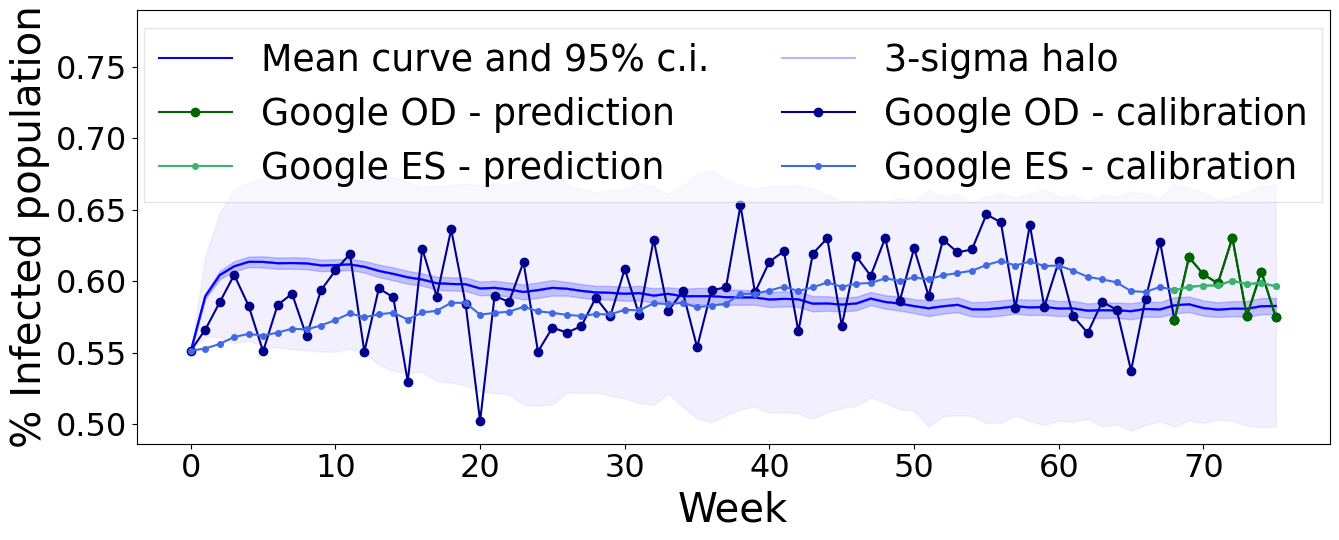

In [50]:
# plt.figure(figsize=(8,5))
plt.figure(figsize=(13.5,5.5))


sns.lineplot(
    data=results_vala1.arrange_variables(),
    x='t',
    y='I',
    errorbar=('se',0),
    color='b',
    label='Mean curve and 95% c.i.'
)

# plt.errorbar(time[0:68], sentiment[0:68], yerr=df_err['Propagation errors'][0:68], fmt='o-',label='Train set', color='purple')
# plt.errorbar(time[67:76], sentiment[67:76], yerr=df_err['Propagation errors'][67:76], fmt='o-',label='Test set', color='darkgreen')
# plt.plot(time[0:69], smoothed_data[0:69], 'o-', label='Train set', color='purple')
# plt.plot(time[68:76], smoothed_data[68:76], '-o', label='Test set', color='darkgreen')

plt.plot(time[68:76], sentiment_Amazon[68:76], '-o', label='Google OD - prediction', color='darkgreen')
# plt.plot(time[0:76], smoothed_data[0:76], 'o-', markersize=4, label='Amazon ES', color='mediumorchid')

plt.plot(time[68:76],smoothed_data_a[68:76], 'o-', markersize=4, label='Google ES - prediction', color='mediumseagreen')

sns.lineplot(
    data=results_vala1.arrange_variables(),
    x='t',
    y='I',
    # hue='iteration',
    legend=True,
    errorbar=('sd',3),
    # palette=['lavender']
    color='#C1B4FF',
    label='3-sigma halo'
)

sns.lineplot(
    data=results_vala1.arrange_variables(),
    x='t',
    y='I',
    errorbar=('se',2),
    color='b'
)

plt.plot(time[0:69], sentiment_Amazon[0:69], 'o-', label='Google OD - calibration', color='darkblue')
plt.plot(time[0:69],smoothed_data_a[0:69], 'o-', markersize=4, label='Google ES - calibration', color='royalblue')

plt.plot(time[68:76], sentiment_Amazon[68:76], '-o', color='darkgreen')
plt.plot(time[68:76],smoothed_data_a[68:76], 'o-', markersize=4, color='mediumseagreen')

plt.xlabel("Week", fontsize=29)
plt.ylabel("% Infected population", fontsize=29)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

ymin, ymax = plt.ylim()
plt.ylim(ymin, ymax * 1.15)

plt.tight_layout()
plt.legend(fontsize=26.2, ncol=2, fancybox=False, loc='upper center', framealpha=0.5)

# plt.savefig(r"Google_76_steps_final1.pdf")
plt.draw()

In [51]:
dy=results_vala1.arrange_variables()
media_I = dy.groupby('t')['I'].mean().reset_index(name='I_media')
# media_I['I_media']
avg_distance=np.abs((np.sum(smoothed_data_a[68:76]-media_I['I_media'][68:76]))/8)
avg_distance

np.float64(0.015272679230325409)

#### Plot

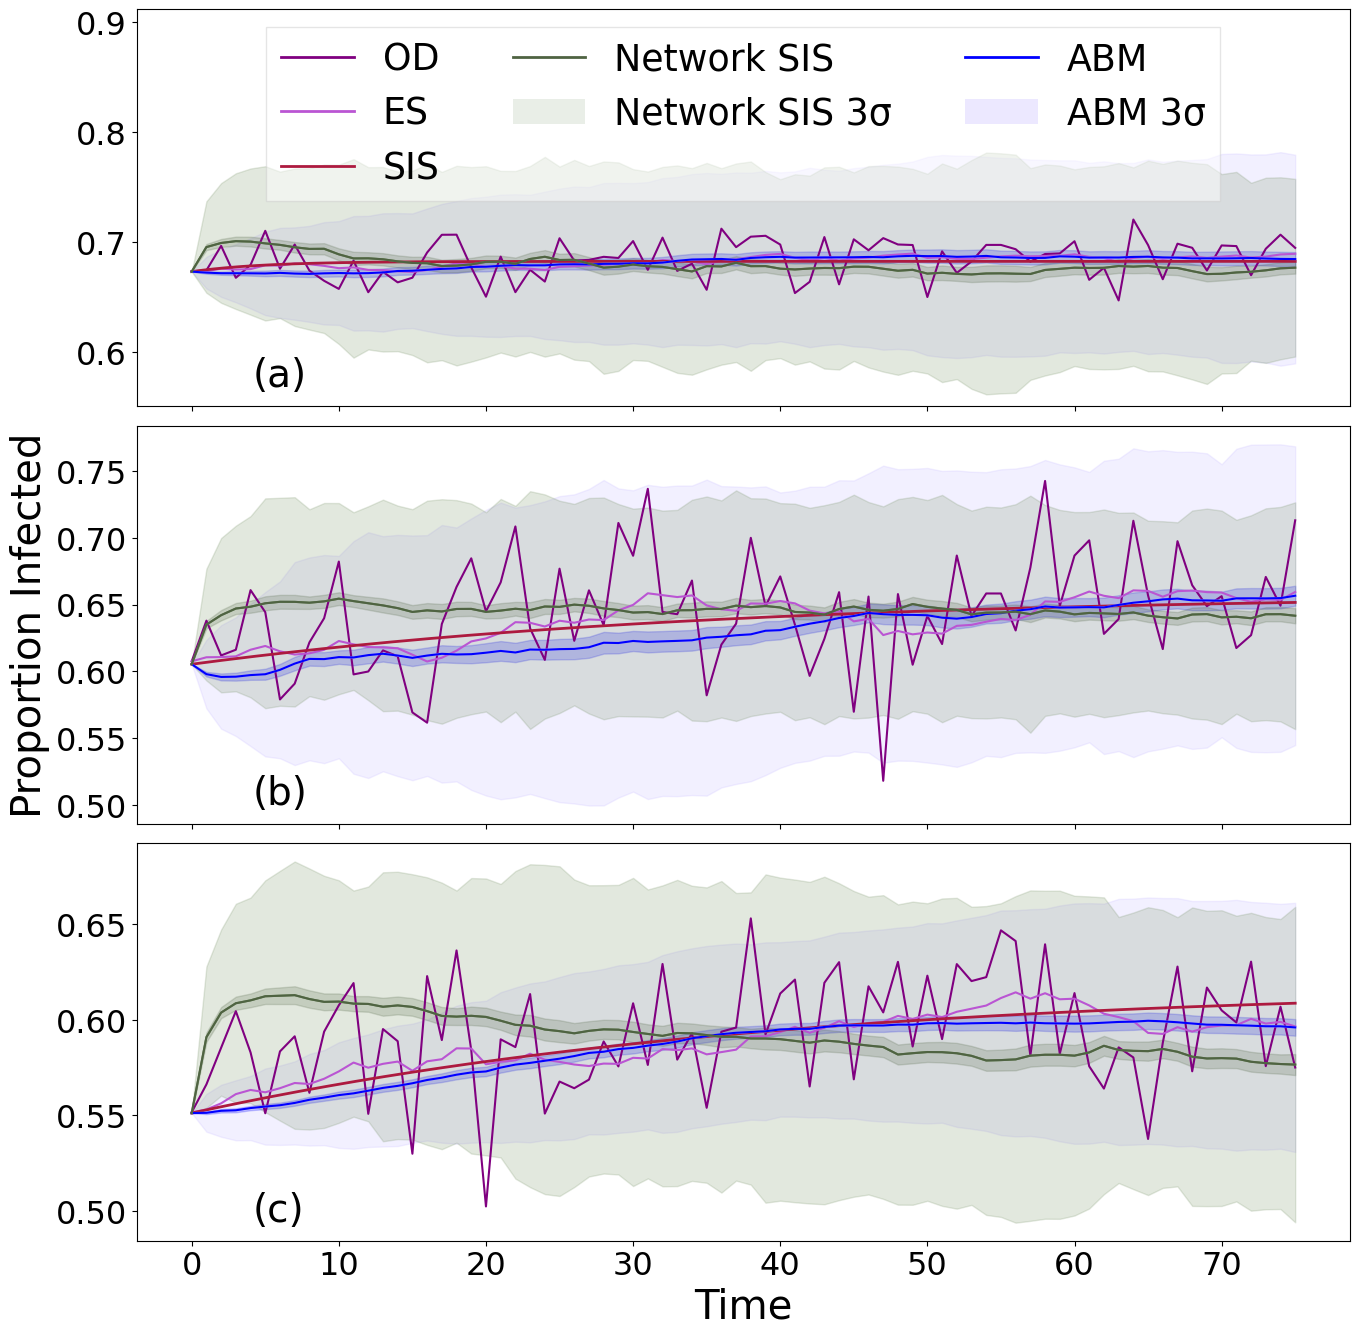

In [ ]:
def deriv(i, t, beta, gamma):
    return beta * i * (1 - i) - gamma * i

N = len(graph.nodes)

beta_det_g=0.3014
gamma_det_g=0.0957

beta_det=0.0464
gamma_det=0.0159

beta_det_a=0.0465
gamma_det_a=0.0178

tmax = 75
n_simulations = 100
i0_g = 0.6731517509727627
i0 = 0.6054421768707483
i0_a = 0.5511811023622047
t_eval = np.linspace(0, tmax, 500) 

i_det_g = odeint(deriv, i0_g, t_eval, args=(beta_det_g, gamma_det_g)).flatten()
i_det = odeint(deriv, i0, t_eval, args=(beta_det, gamma_det)).flatten()
i_det_a = odeint(deriv, i0_a, t_eval, args=(beta_det_a, gamma_det_a)).flatten()

fig, axes = plt.subplots(3, 1, figsize=(13.5, 13.5), sharex=True, sharey=False)

# Google
axes[0].plot(sentiment_Google, '-', markersize=4, color='purple')
axes[0].plot(smoothed_data_g, '-', markersize=4, color='mediumorchid')
axes[0].plot(t_eval, i_det_g, color="#AD1A3F", linewidth=2)

sns.lineplot(
    data=results_valg.arrange_variables(),
    x='t', y='I', errorbar=('sd', 3), color='#C1B4FF', legend=False, ax=axes[0]
)
sns.lineplot(
    data=results_valg.arrange_variables(),
    x='t', y='I', errorbar=('se', 2), color='b', ax=axes[0]
)

sns.lineplot(
    data=results_valg1.arrange_variables(),
    x='t', y='I', errorbar=('sd', 3), color='#708D5E', legend=False, ax=axes[0]
)
sns.lineplot(
    data=results_valg1.arrange_variables(),
    x='t', y='I', errorbar=('se', 2), color='#4F6342', ax=axes[0]
)

axes[0].set_xlabel('Time', fontsize=20, color='white')
axes[0].set_ylabel('Proportion Infected', fontsize=20, color='white')
axes[0].tick_params(labelsize=23)

axes[0].text(0.0955, 0.05, '(a)', transform=axes[0].transAxes, fontsize=28)

ymin, ymax=axes[0].get_ylim()
axes[0].set_ylim(ymin, ymax * 1.15)

# xmin, xmax=axes[0].get_xlim()
# axes[0].set_xlim(xmin, xmax * 1.01)

# Apple
axes[1].plot(sentiment, '-', markersize=4, color='purple')
axes[1].plot(smoothed_data, '-', markersize=4, color='mediumorchid')
axes[1].plot(t_eval, i_det, color="#AD1A3F", linewidth=2)

sns.lineplot(
    data=results_val.arrange_variables(),
    x='t', y='I', errorbar=('sd', 3), color='#C1B4FF', legend=False, ax=axes[1]
)
sns.lineplot(
    data=results_val.arrange_variables(),
    x='t', y='I', errorbar=('se', 2), color='b', ax=axes[1]
)

sns.lineplot(
    data=results_val1.arrange_variables(),
    x='t', y='I', errorbar=('sd', 3), color='#708D5E', legend=False, ax=axes[1]
)
sns.lineplot(
    data=results_val1.arrange_variables(),
    x='t', y='I', errorbar=('se', 2), color='#4F6342', ax=axes[1]
)

axes[1].set_xlabel('Time', fontsize=20, color='white')
axes[1].set_ylabel('Proportion Infected', fontsize=29)
axes[1].tick_params(labelsize=23)

axes[1].text(0.0955, -1, '(b)', transform=axes[0].transAxes, fontsize=28)


# Amazon
axes[2].plot(sentiment_Amazon, '-', markersize=4, color='purple')
axes[2].plot(smoothed_data_a, '-', markersize=4, color='mediumorchid')
axes[2].plot(t_eval, i_det_a, color="#AD1A3F", linewidth=2)

sns.lineplot(
    data=results_vala.arrange_variables(),
    x='t', y='I', errorbar=('sd', 3), color='#C1B4FF', legend=False, ax=axes[2]
)
sns.lineplot(
    data=results_vala.arrange_variables(),
    x='t', y='I', errorbar=('se', 2), color='b', ax=axes[2]
)

sns.lineplot(
    data=results_vala1.arrange_variables(),
    x='t', y='I', errorbar=('sd', 3), color='#708D5E', legend=False, ax=axes[2]
)
sns.lineplot(
    data=results_vala1.arrange_variables(),
    x='t', y='I', errorbar=('se', 2), color='#4F6342', ax=axes[2]
)

axes[2].set_xlabel('Time', fontsize=29)
axes[2].set_ylabel('Proportion Infected', fontsize=20, color='white')
axes[2].tick_params(labelsize=23)

axes[2].text(0.0955, -2.05, '(c)', transform=axes[0].transAxes, fontsize=28)

# --- Legenda solo nel primo subplot
custom_legend = [
    Line2D([0], [0], color='purple', label='OD', lw=2),
    Line2D([0], [0], color='mediumorchid', label='ES', lw=2),
    Line2D([0], [0], color="#AD1A3F", lw=2, label='SIS'),
    Line2D([0], [0], color="#4F6342", lw=2, label='Network SIS'),
    Patch(facecolor="#708D5E", alpha=0.15, label='Network SIS 3σ'),
    Line2D([0], [0], color="b", lw=2, label='ABM'),
    Patch(facecolor="#C1B4FF", alpha=0.3, label='ABM 3σ')
]
axes[0].legend(handles=custom_legend, fontsize=26.2, ncols=3, loc='upper center',
               fancybox=False, framealpha=0.5)

plt.tight_layout()
plt.draw()

# ymin, ymax = plt.ylim()
# plt.ylim(ymin, ymax * 1.15)

# plt.savefig(r"panel1.pdf")

### TRUST UPDATE VISUALIZATION


Al tempo t: 75 i trust diversi da 0.5 sono: 2646
Al tempo t: 58 i trust diversi da 0.5 sono: 2646
Al tempo t: 39 i trust diversi da 0.5 sono: 2646
Al tempo t: 20 i trust diversi da 0.5 sono: 2646
Al tempo t: 1 i trust diversi da 0.5 sono: 2646


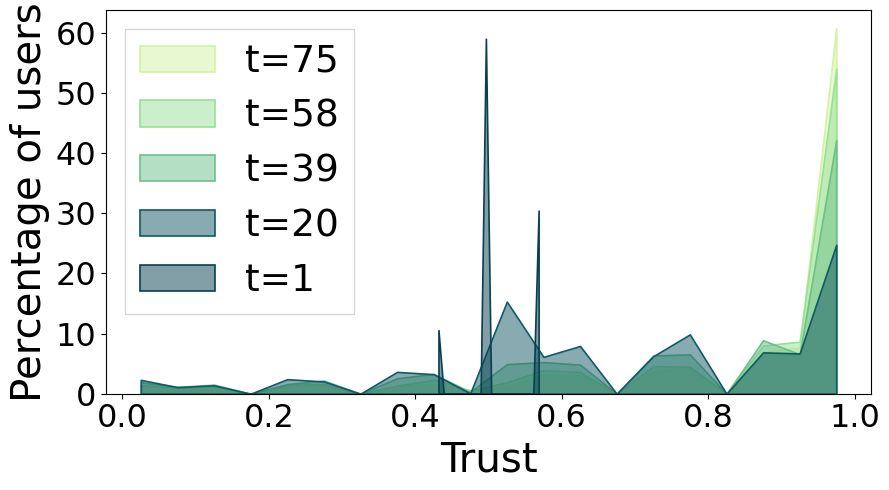

In [ ]:
# ONE COMPANY
A = nx.to_numpy_array(graph)
max_time=len(results.variables.Sentiment_diffusion['other_trust'])
plt.figure(figsize=(9,5))
for t in (75,58,39,20,1): #(1,16,32,48,76):#reversed(range(1,max_time,16)):
    trust_list=[]
    trust_high=[]
    list_popular_agents=[]
    list_other=[]
    for i in range(len(results.variables.Sentiment_diffusion['other_trust'][t])):
        for id,trust in enumerate(results.variables.Sentiment_diffusion['other_trust'][t][i]):
            if (A[i][id]!=0):
            # if (trust!=0.5):
                trust_list.append(trust)
                list_popular_agents.append(int(id))
                list_other.append(int(id+1))
    print('Al tempo t: '+str(t)+ ' i trust diversi da 0.5 sono: '+str(len(trust_list)))
    d_trust={'T':trust_list,'i':list_popular_agents,'j':list_other}
    T=pd.DataFrame(data=d_trust)

    from palettable.cartocolors.sequential import Emrld_6

    base_color = Emrld_6.mpl_colors[5-round(t/15)]  # ad esempio verde tenue

    # Istogramma con trasparenza
    sns.histplot(
        T['T'],
        bins=20,
        stat='percent',
        element='poly',
        color=base_color,
        edgecolor=base_color,
        linewidth=1.2,
        alpha=0.5,
        label='t='+str(t)
    )

    plt.xlabel('Trust', fontsize=29)
    plt.ylabel('Percentage of users',fontsize=29)
    plt.xticks(fontsize=23)
    plt.yticks(fontsize=23)

    plt.legend(fancybox=False, fontsize=27)
    plt.tight_layout()
    plt.draw()

    # plt.savefig(r'Amazon_trust_over_time.pdf')

    # sns.histplot(T['T'], bins=20, stat='percent', element='poly', palette=)
    # plt.draw()

        

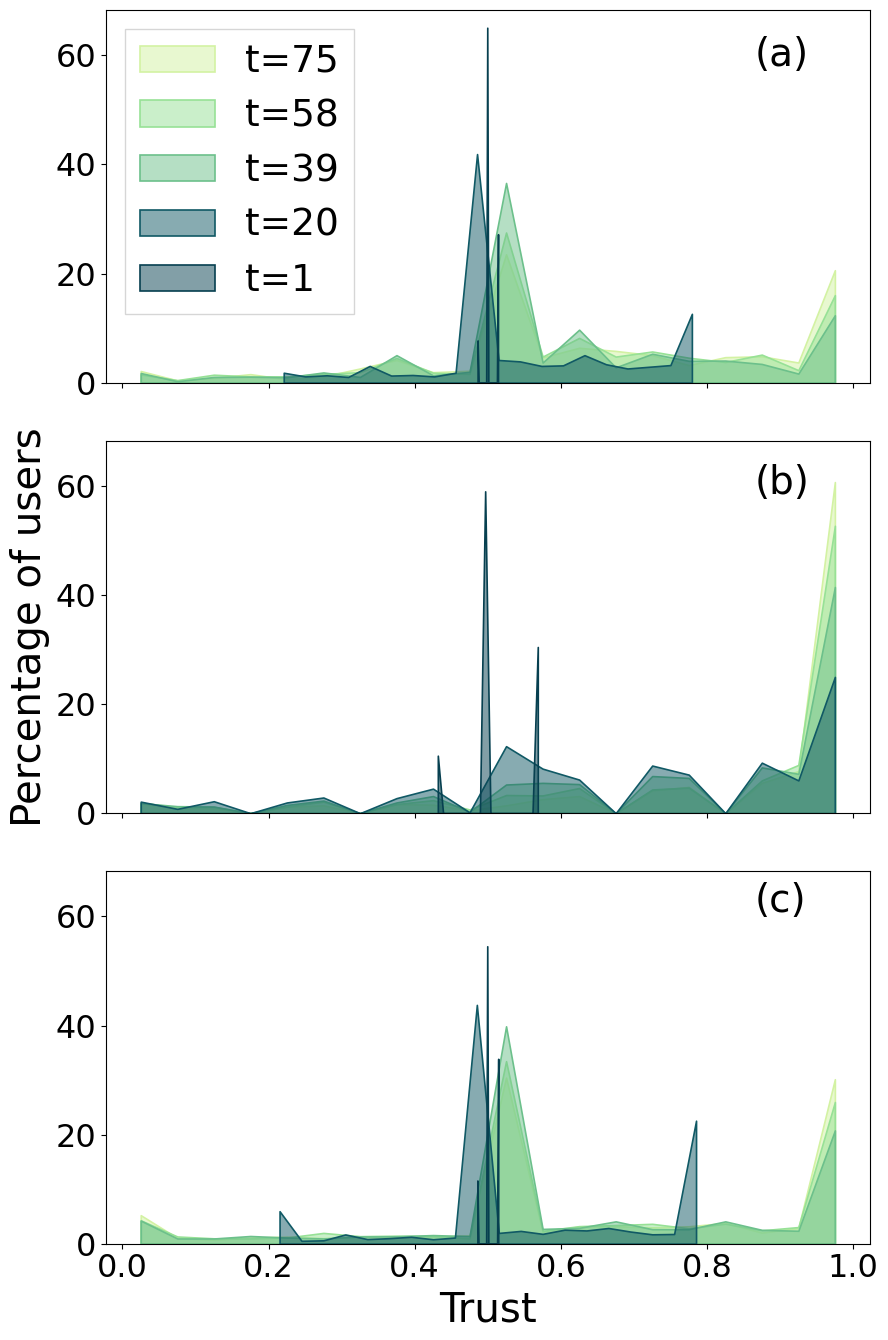

In [ ]:
# PLOT FOR THREE COMPANIES TOGETHER
graph_apple = nx.read_graphml(r"/mnt/c/Users/barat/Documents/Dottorato/AAA_Main_project/Network/apple_network_5_months_right_sentiment.graphml")
graph_google = nx.read_graphml(r"/mnt/c/Users/barat/Documents/Dottorato/AAA_Main_project/Network/google_network_5_months_right_sentiment.graphml")
graph_amazon = nx.read_graphml(r"/mnt/c/Users/barat/Documents/Dottorato/AAA_Main_project/Network/amazon_network_5_months_right_sentiment.graphml")

A_apple = nx.to_numpy_array(graph_apple)
A_google = nx.to_numpy_array(graph_google)
A_amazon = nx.to_numpy_array(graph_amazon)

max_time = len(results_apple.variables.Sentiment_diffusion['other_trust'])

fig, axes = plt.subplots(3, 1, figsize=(9, 13.5), sharex=True, sharey=True)

# ---------- SUBPLOT 1 ----------
for t in (75, 58, 39, 20, 1):
    trust_list = []
    list_popular_agents = []
    list_other = []
    for i in range(len(results_google.variables.Sentiment_diffusion['other_trust'][t])):
        for id, trust in enumerate(results_google.variables.Sentiment_diffusion['other_trust'][t][i]):
            if (A_google[i][id] != 0):
                trust_list.append(trust)
                list_popular_agents.append(int(id))
                list_other.append(int(id+1))

    d_trust = {'T': trust_list, 'i': list_popular_agents, 'j': list_other}
    T = pd.DataFrame(data=d_trust)

    from palettable.cartocolors.sequential import Emrld_6
    base_color = Emrld_6.mpl_colors[5 - round(t/15)]

    sns.histplot(
        T['T'],
        bins=20, stat='percent', element='poly',
        color=base_color, edgecolor=base_color,
        linewidth=1.2, alpha=0.5,
        label='t=' + str(t),
        ax=axes[0]
    )

axes[0].set_xlabel('Trust', fontsize=20, color='white')
axes[0].set_ylabel('Percentage of users', fontsize=20, color='white')
axes[0].tick_params(labelsize=23)
axes[0].legend(fancybox=False, fontsize=27)

axes[0].text(0.85, 0.85, '(a)', transform=axes[0].transAxes, fontsize=28)

# ---------- SUBPLOT 2 ----------
for t in (75, 58, 39, 20, 1):
    trust_list = []
    list_popular_agents = []
    list_other = []
    for i in range(len(results_apple.variables.Sentiment_diffusion['other_trust'][t])):
        for id, trust in enumerate(results_apple.variables.Sentiment_diffusion['other_trust'][t][i]):
            if (A_apple[i][id] != 0):
                trust_list.append(trust)
                list_popular_agents.append(int(id))
                list_other.append(int(id+1))

    d_trust = {'T': trust_list, 'i': list_popular_agents, 'j': list_other}
    T = pd.DataFrame(data=d_trust)

    from palettable.cartocolors.sequential import Emrld_6
    base_color = Emrld_6.mpl_colors[5 - round(t/15)]

    sns.histplot(
        T['T'],
        bins=20, stat='percent', element='poly',
        color=base_color, edgecolor=base_color,
        linewidth=1.2, alpha=0.5,
        label='t=' + str(t),
        ax=axes[1]
    )

axes[1].set_xlabel('Trust', fontsize=20, color='white')
axes[1].set_ylabel('Percentage of users', fontsize=29)
axes[1].tick_params(labelsize=23)
# axes[1].legend(fancybox=False, fontsize=27)

axes[1].text(0.85, -0.3, '(b)', transform=axes[0].transAxes, fontsize=28)

# ---------- SUBPLOT 3 ----------
for t in (75, 58, 39, 20, 1):
    trust_list = []
    list_popular_agents = []
    list_other = []
    for i in range(len(results_amazon.variables.Sentiment_diffusion['other_trust'][t])):
        for id, trust in enumerate(results_amazon.variables.Sentiment_diffusion['other_trust'][t][i]):
            if (A_amazon[i][id] != 0):
                trust_list.append(trust)
                list_popular_agents.append(int(id))
                list_other.append(int(id+1))

    d_trust = {'T': trust_list, 'i': list_popular_agents, 'j': list_other}
    T = pd.DataFrame(data=d_trust)

    from palettable.cartocolors.sequential import Emrld_6
    base_color = Emrld_6.mpl_colors[5 - round(t/15)]

    sns.histplot(
        T['T'],
        bins=20, stat='percent', element='poly',
        color=base_color, edgecolor=base_color,
        linewidth=1.2, alpha=0.5,
        label='t=' + str(t),
        ax=axes[2]
    )

axes[2].set_xlabel('Trust', fontsize=29)
axes[2].set_ylabel('Percentage of users', fontsize=20, color='white')
axes[2].tick_params(labelsize=23)
# axes[2].legend(fancybox=False, fontsize=27)

axes[2].text(0.85, -1.42, '(c)', transform=axes[0].transAxes, fontsize=28)


plt.tight_layout()
plt.draw()
# plt.savefig(r'panel_trust.pdf')